# Personal view

The most common feature that help in detection of heart desease are:

- **chest pain type:**

It is not a good **indicator** to show CAD diseases becasue of in the different syptoms, the majority of its values tend to give **no disease**

![chest pain type-count_plot.jpg](attachment:e93895e5-5eb5-4ac4-84da-fd0a88c5f179.jpg)

- **exercise induced angina**

It is a good **indicator** to show CAD diseases becasue the **No** value gives bigger priority for no CAD diseases

![exercise induced angina-count_plot.jpg](attachment:99b9579c-6696-4935-8414-e819fd42d893.jpg)

- **the slop of ST segment**

It is a good **indicator** to show CAD diseases becasue there its values help in distinguishing if there is CAD diseases.

![slope peak exercise ST segment-count_plot.jpg](attachment:966df1dc-b2cb-40b8-a763-0317036a6ad7.jpg)
![download.png](attachment:76589c46-b978-4f07-891a-8c56f7f0e131.png)

- **thallium stress result:**

the flow of blood to your heart through your coronary arteries, An abnormal test result can reveal coronary blockages as well as damage from heart attacks

It is a good **indicator**

![thallium stress result-count_plot.jpg](attachment:8e68998b-05a6-4dc2-bd1c-f6dca054b5f1.jpg)

- **max heart rate**
- **age**
- **ST depression**


In [43]:
PROC_TRAIN_DATA_PATH = "../../data/processed/preprocessed_train_data.pkl"
SELECTED_TRAIN_DATA_PATH = "../../data/preprocessed/selected_train_data.pkl"
FEATURES_SELECTION_METHODS_PATH = "../../reports/files/filter_embedded_comp.csv"

# Import packages


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import Union, Callable

# Import estimators
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from genetic_selection import GeneticSelectionCV

# Import imputing features methods
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer


# Import features selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    RFECV,
    SequentialFeatureSelector,
)

from skfeature.function.similarity_based.fisher_score import fisher_score

from mlxtend.feature_selection import SequentialFeatureSelector as mlx_sfs
from mlxtend.plotting import plot_sequential_feature_selection


from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings

warnings.filterwarnings("ignore")

In [5]:
# Change some pandas display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 1000)
pd.set_option("styler.format.precision", 10)

# Read data


In [6]:
df_train = pd.read_pickle(PROC_TRAIN_DATA_PATH)

num_cols = [
    "age",
    "resting_blood_pressure",
    "serum_cholestoral",
    "maximum_heart_rate",
    "ST_depression",
]
cat_cols = set(df_train.columns.to_list()) - set(num_cols)
cat_cols = list(cat_cols)

# Replace nan values


In [7]:
df_train[["number_of_major_vessels", "thallium_stress_result"]] = SimpleImputer(
    strategy="most_frequent"
).fit_transform(df_train[["number_of_major_vessels", "thallium_stress_result"]])

# Normality

**Cholesterol** and **ST depression** are not follow the normal distribution<br>
so we will transform them to be normally distributed


In [8]:
# rng = np.random.RandomState(304)
# qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
#                                 random_state=rng)
# df_train[["serum cholestoral","ST depression"]] = qt.fit_transform(df_train[["serum cholestoral","ST depression"]])
# # test_data[["serum cholestoral","ST depression"]] = qt.transform(test_data[["serum cholestoral","ST depression"]])

# Selection


### Filter methods

The current problem contains independent features with categorical target. <br>
Therefore the desired filter methods to be used are **Chi2** and **LDA**:

1. For measuring the independence between Continues features and categorical target, The LDA algorithm should be used because:

   - LDA: Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

2. For measuring the independence between categorical features and categorical target, The chi2 test should be used because:
   - Chi-Square: It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.


#### Correlation


<AxesSubplot:>

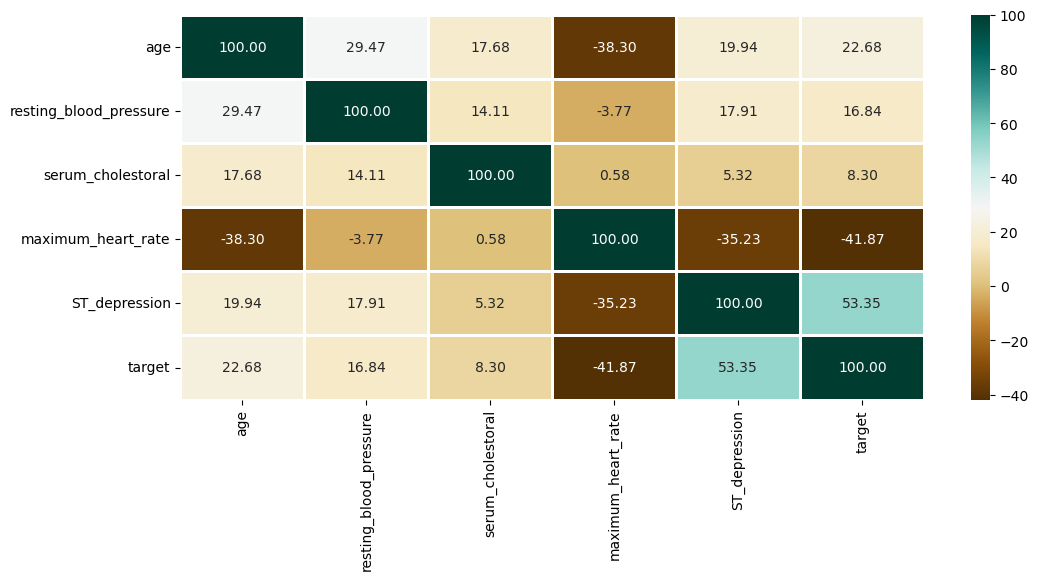

In [9]:
corr_values = df_train[num_cols + ["target"]].corr()

plt.figure(figsize=(12, 5))
sns.heatmap(
    corr_values * 100,
    linecolor="w",
    linewidths=1,
    annot=True,
    fmt=".2f",
    cmap=plt.cm.BrBG,
)

#### Multicollinearity Detecting

Variable Inflation Factors (VIF):

- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others


In [10]:
vif = pd.DataFrame()
vif_corr_values = df_train[num_cols].corr()
vif["variables"] = vif_corr_values.columns
vif["VIF"] = [
    variance_inflation_factor(vif_corr_values.values, i)
    for i in range(vif_corr_values.shape[1])
]
vif

,variables,VIF
0,age,2.800337
1,resting_blood_pressure,1.691991
2,serum_cholestoral,1.214511
3,maximum_heart_rate,2.775888
4,ST_depression,1.906737


#### Drawing test scores - bar plot


In [128]:
@dataclass
class RankResult:
    """class for storing test results"""

    specs: list[str]
    scores: list[Union[int, float]]
    data: pd.DataFrame = field(init=False, repr=False)

    def __post_init__(self):
        # Grouping results in DataFrame
        self.data = pd.DataFrame()
        self.data["Spec"] = self.specs
        self.data["Score"] = self.scores


@dataclass
class FeatureRank:
    """Class holding feature ranking from the ranking method"""

    method: Callable[[pd.DataFrame, pd.DataFrame], list[int]]
    rank_result: RankResult = field(init=False)

    def get_ranks(self, X: pd.DataFrame, y: pd.DataFrame):
        # Calculate feature ranking
        ret = self.method(X.to_numpy(), y.to_numpy())

        # Create test data
        scores = ret[0] if (len(ret) == 2) else ret

        # Normalize scores
        scores = (scores - scores.min()) / (scores.max() - scores.min())

        self.rank_result = RankResult(specs=X.columns, scores=scores)

        # Change the index of the DataFrame
        self.rank_result.data.index = [
            X.columns.get_loc(spec) for spec in self.rank_result.data["Spec"]
        ]

        return self

    def get_largest_score(self, num_feats: int = None) -> list[str]:
        """Get the largest ranks of features

        Args:
            n (Union[int, str], optional): number of features to get. Defaults to 'auto'.

        Returns:
            list[str]: list of n largest features' ranks
        """
        if not num_feats:
            num_feats = self.rank_result.data.shape[0]

        return self.rank_result.data.nlargest(n=num_feats, columns=["Score"])[
            "Specs"
        ].values.tolist()

    def plot_scores(self, title, sorting=False):
        """Plot feature importance as bar plot"""

        # Take copy of data to avoid modifying on original data
        data = self.rank_result.data.copy()

        if sorting:
            data = data.sort_values(by="Score", ascending=False)

        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot()
        axs = sns.barplot(
            y="Spec", x="Score", data=data, palette="Greens_r", orient="h", ax=ax
        )
        for p in axs.patches:
            axs.annotate("{:.2f}".format(p.get_height()), (p.get_x(), p.get_height()))
        plt.box(False)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("\n Features")
        ax.set_ylabel("Importance \n")
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

        return ax

#### Mutual-info method


<AxesSubplot:title={'center':'Mutual-info Test - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

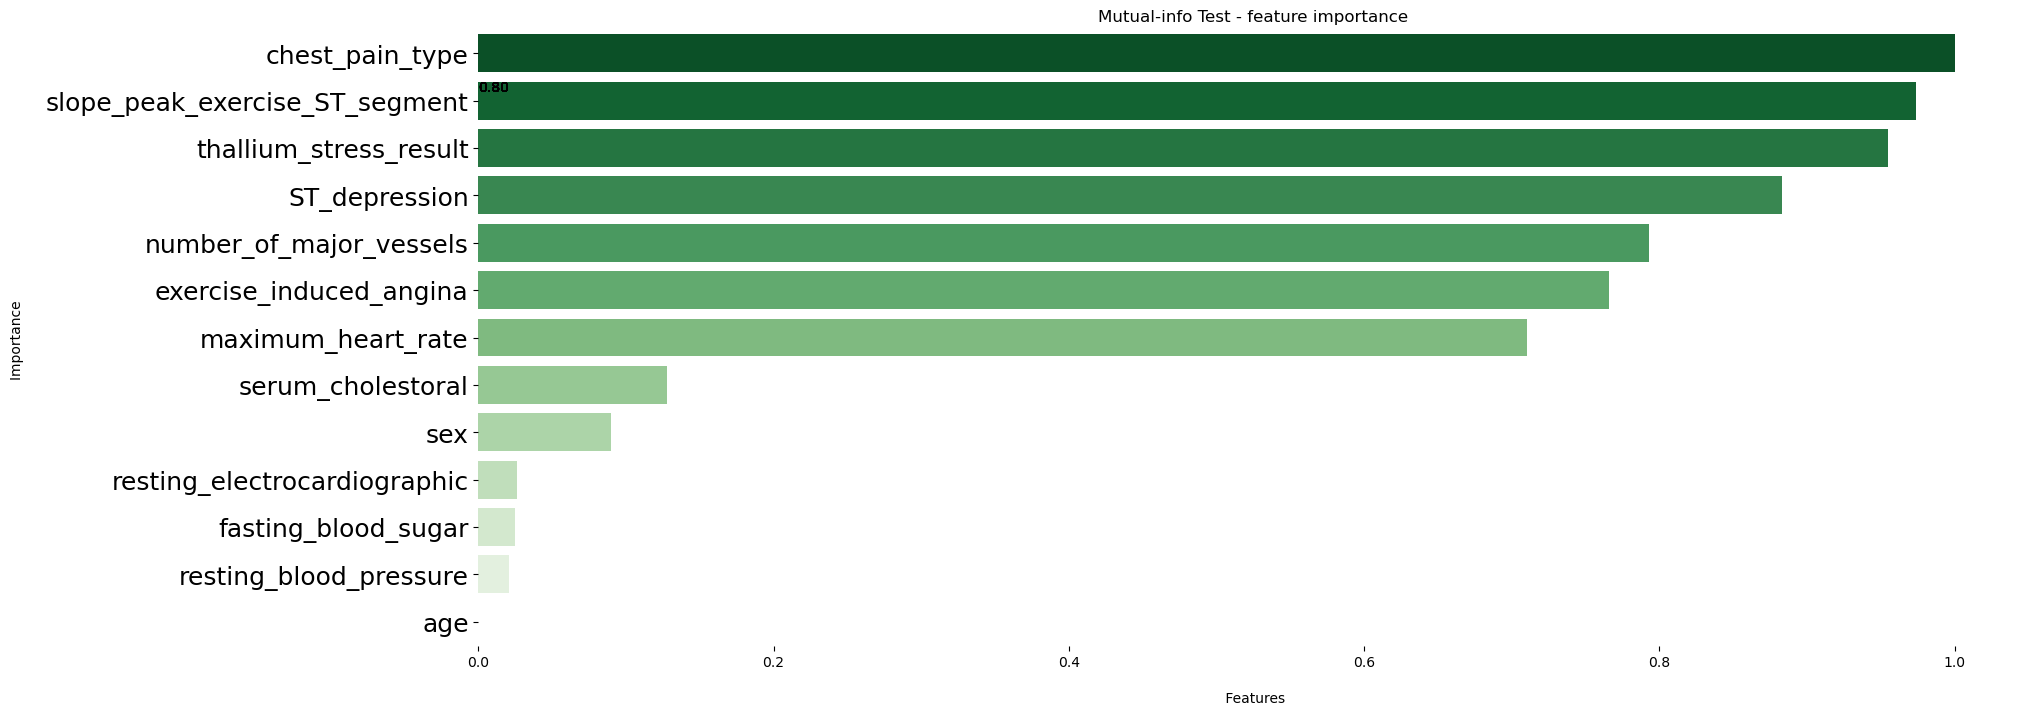

In [129]:
mi_rank = FeatureRank(mutual_info_classif).get_ranks(
    df_train.iloc[:, :-1], df_train["target"]
)
mi_rank.plot_scores("Mutual-info Test - feature importance", sorting=True)

#### Fisher's Score


<AxesSubplot:title={'center':'Fisher Score - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

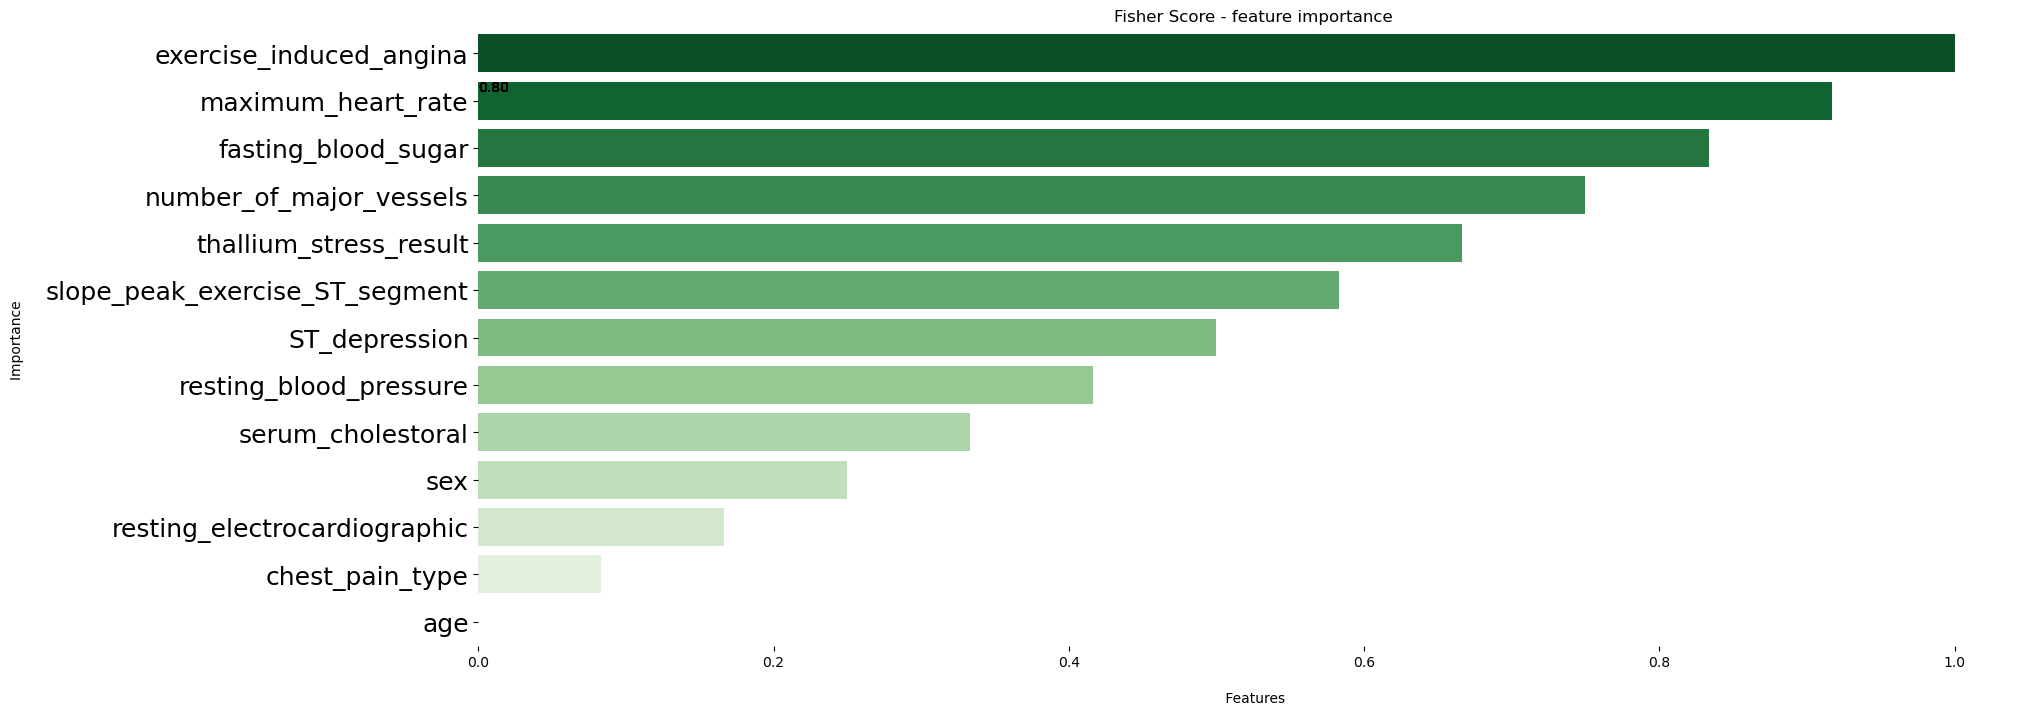

In [130]:
fisher_rank = FeatureRank(fisher_score).get_ranks(
    df_train.iloc[:, :-1], df_train["target"]
)
fisher_rank.plot_scores("Fisher Score - feature importance", sorting=True)

#### Comparison


In [161]:
filter_methods_comp = pd.DataFrame(
    data={
        "features": df_train.columns[:-1],
        "mutual_info": mi_rank.rank_result.data["Score"],
        "fisher_score": fisher_rank.rank_result.data["Score"],
    },
)
filter_methods_comp = filter_methods_comp.set_index("features")
# filter_methods_comp = filter_methods_comp.sort_values(by="mutual_info")
filter_methods_comp.style.applymap(
    lambda x: "color: green" if x > 0.3 else "color: red",
)

,mutual_info,fisher_score
features,,
age,0.0000000000,0.0000000000
sex,0.0899158677,0.2500000000
chest_pain_type,1.0000000000,0.0833333333
resting_blood_pressure,0.0209538173,0.4166666667
serum_cholestoral,0.1274875922,0.3333333333
fasting_blood_sugar,0.0245338289,0.8333333333
resting_electrocardiographic,0.0263808580,0.1666666667
maximum_heart_rate,0.7105555497,0.9166666667
exercise_induced_angina,0.7657153328,1.0000000000


### Wrapper methods


#### RFE


<AxesSubplot:title={'center':'RFE Score - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

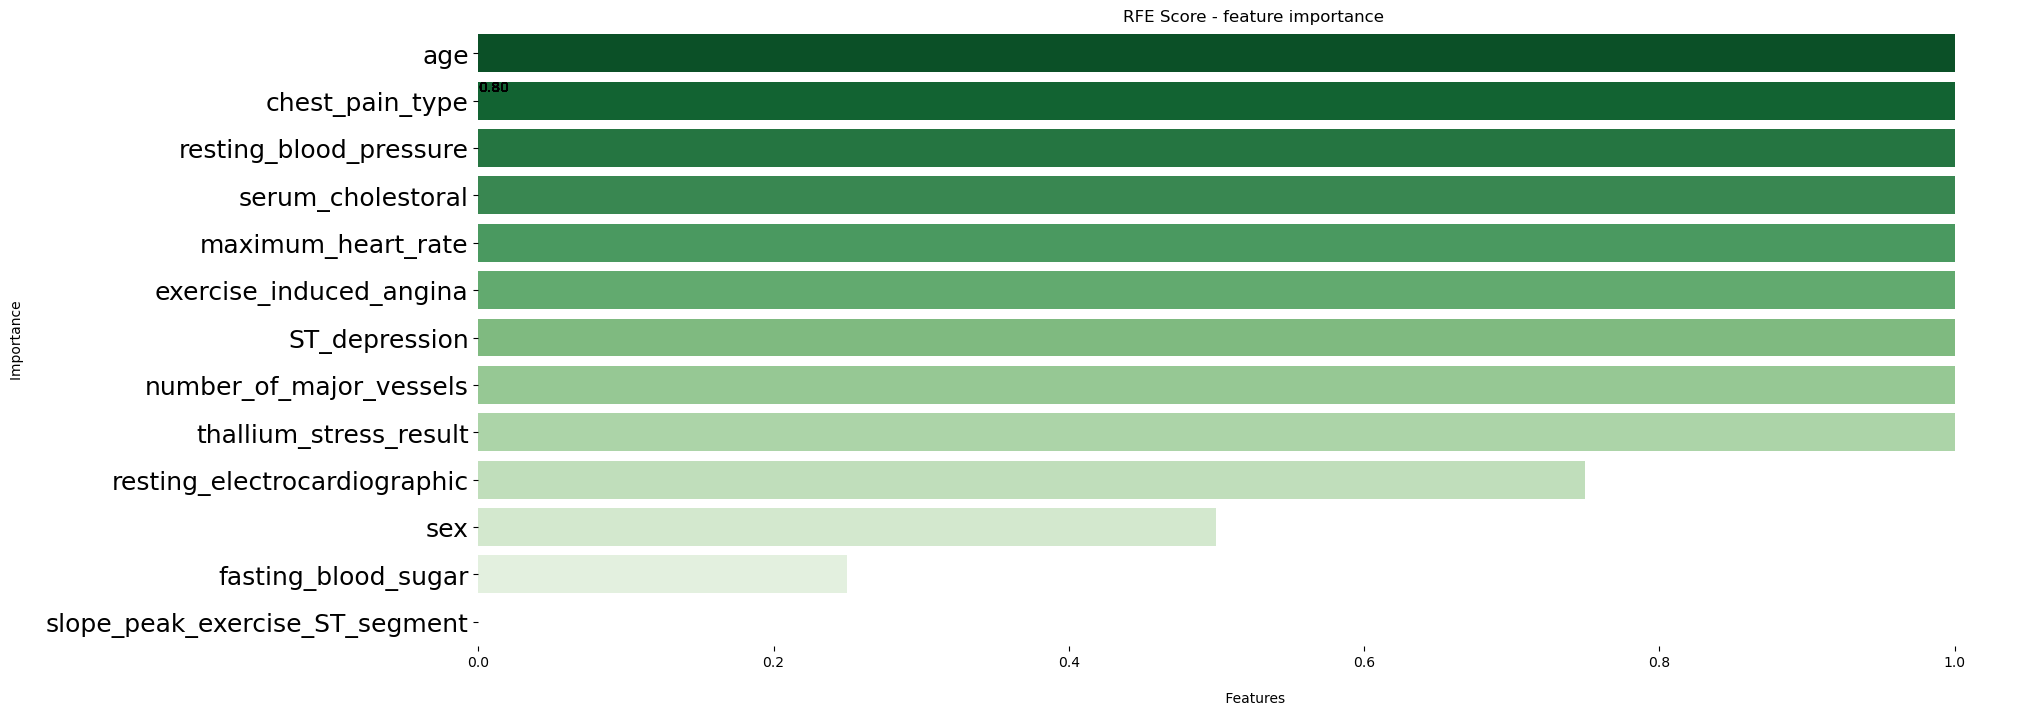

In [132]:
def rfe_score(X, y):
    """Calculate RFE score"""
    dt_classifier = DecisionTreeClassifier(criterion="entropy")
    rfe = RFECV(dt_classifier, step=1, cv=10)
    rfe.fit(X, y)

    ranks = abs(rfe.ranking_ - rfe.ranking_.max())
    return ranks


rfe_rank = FeatureRank(rfe_score).get_ranks(df_train.iloc[:, :-1], df_train["target"])
rfe_rank.plot_scores("RFE Score - feature importance", sorting=True)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)


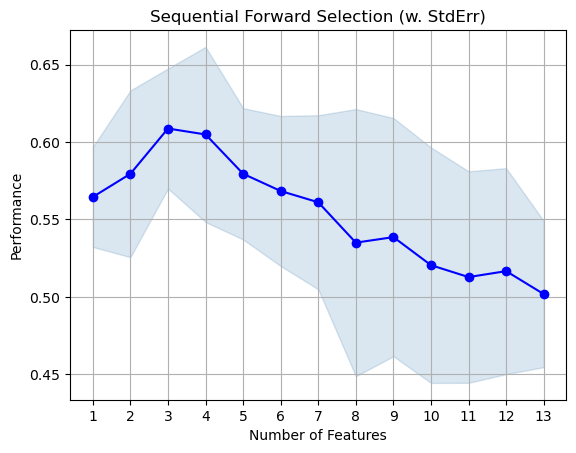

In [133]:
def sfs_score(X, y):
    mlx_sfs_selector = mlx_sfs(
        DecisionTreeClassifier(),
        k_features=X.shape[1],
        forward=True,
        floating=False,
        scoring="accuracy",
        cv=10,
        n_jobs=-1,
    ).fit(X, y)
    # mlx_sfs_features = mlx_sfs_selector.k_feature_names_
    print(mlx_sfs_selector.k_feature_idx_)
    mlx_sfs_scores = mlx_sfs_selector.get_metric_dict()
    return mlx_sfs_scores


# sfs_rank = FeatureRank(sfs_score).get_ranks(df_train.iloc[:, :-1], df_train["target"])
# sfs_rank.plot_scores("SFS Score - feature importance", sorting=True)


fig1 = plot_sequential_feature_selection(
    sfs_score(df_train.iloc[:, :-1], df_train["target"]), kind="std_dev"
)
plt.title("Sequential Forward Selection (w. StdErr)")
plt.grid()
plt.show()

#### Genetic Algorithm


In [134]:
genetic_model_selector = GeneticSelectionCV(
    SVC(),
    cv=5,
    verbose=0,
    scoring="precision",
    n_population=100,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)

genetic_model_selector = genetic_model_selector.fit(
    df_train.iloc[:, :-1], df_train["target"]
)

genetic_features = df_train.iloc[:, :-1].columns[genetic_model_selector.support_]

In [135]:
genetic_features

Index(['sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'resting_electrocardiographic', 'maximum_heart_rate', 'exercise_induced_angina', 'ST_depression', 'slope_peak_exercise_ST_segment', 'thallium_stress_result'], dtype='object')

### Embedded methods


#### Tree-Based


<AxesSubplot:title={'center':'Tree-Based - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

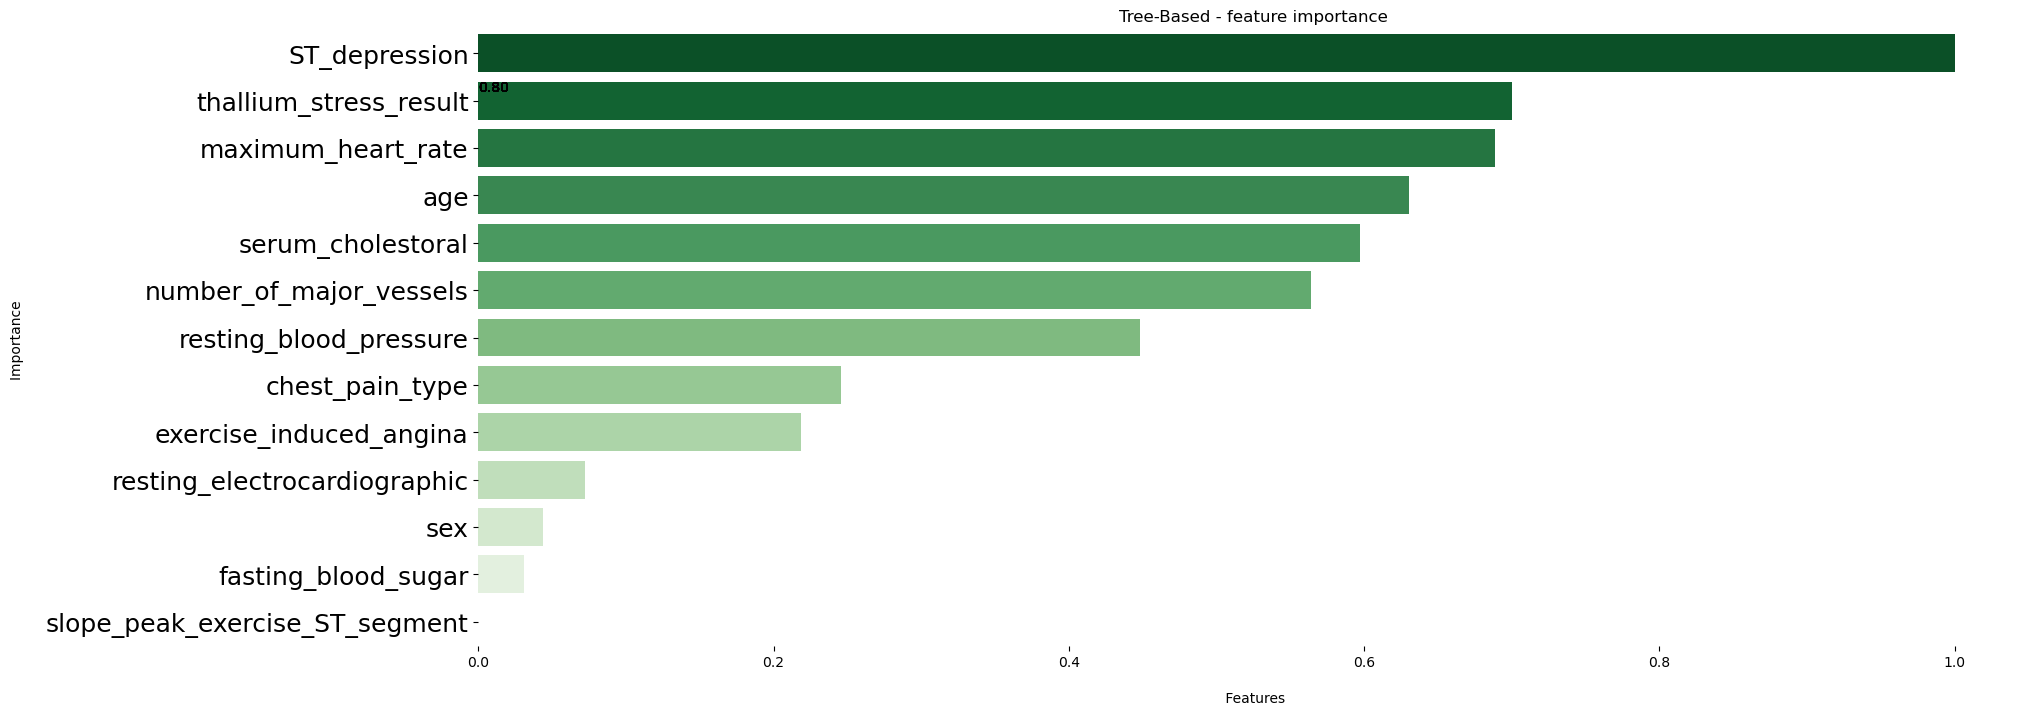

In [191]:
def tree_based_score(X, y):
    """Calculate Tree-based score"""
    dt_model_selector = DecisionTreeClassifier(criterion="entropy")
    dt_model_selector.fit(X, y)
    return dt_model_selector.feature_importances_


tree_based_rank = FeatureRank(tree_based_score).get_ranks(
    df_train.iloc[:, :-1], df_train["target"]
)
tree_based_rank.plot_scores("Tree-Based - feature importance", sorting=True)

#### SVM (L1 regularization)


In [192]:
# def svm_score(X, y):
#     """Calculate svm score"""
#     svm_model_selector = SVC(
#         kernel="linear", decision_function_shape="ovo", random_state=33
#     )
#     svm_model_selector.fit(X, y)
#     print(svm_model_selector.coef_.ravel())
#     return svm_model_selector.coef_.ravel()


# svm_rank = FeatureRank(svm_score).get_ranks(df_train.iloc[:,:-1], df_train['target'])
# svm_rank.plot_scores('svm Score - feature importance', sorting=True)

#### Lasso (L1 regularization)


<AxesSubplot:title={'center':'Lasso - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

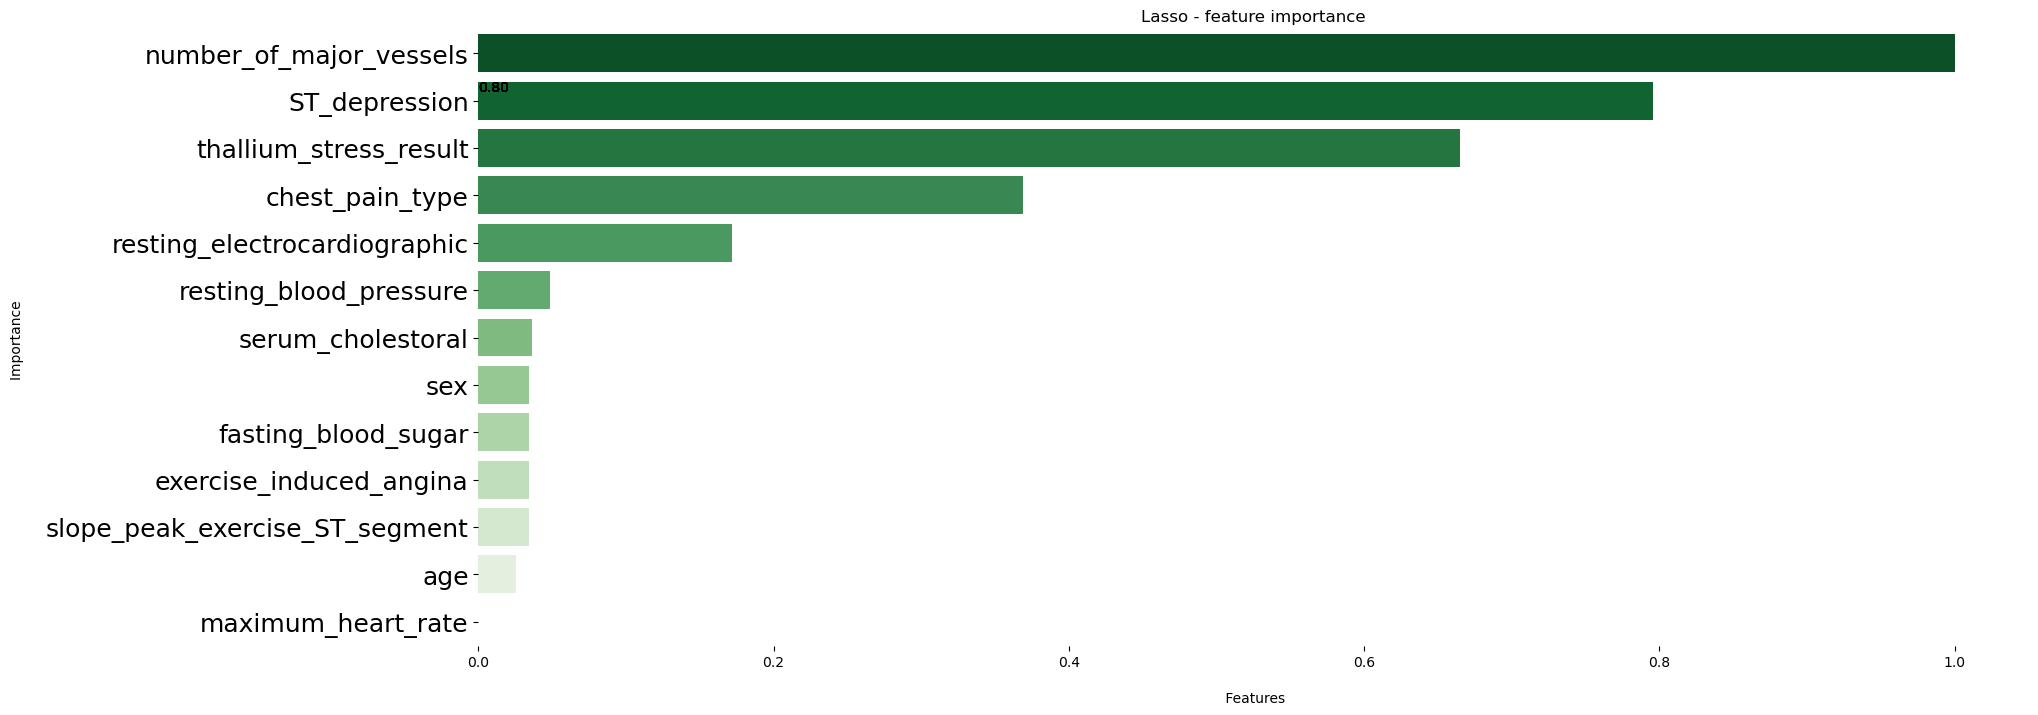

In [193]:
def lasso_score(X, y):
    """Calculate Lasso score"""
    lasso_model_selector = Lasso(alpha=0.1)
    lasso_model_selector.fit(X, y)
    return lasso_model_selector.coef_


lasso_rank = FeatureRank(lasso_score).get_ranks(
    df_train.iloc[:, :-1], df_train["target"]
)
lasso_rank.plot_scores("Lasso - feature importance", sorting=True)

#### Comparison


In [194]:
embedded_methods_comp = pd.DataFrame(
    data={
        "features": df_train.columns[:-1],
        "tree_based": tree_based_rank.rank_result.data["Score"],
        "L1-regularization": lasso_rank.rank_result.data["Score"],
    },
)
embedded_methods_comp = embedded_methods_comp.set_index("features")
# embedded_methods_comp = embedded_methods_comp.sort_values(by="tree_based")
embedded_methods_comp.style.applymap(
    lambda x: "color: green" if x > 0.3 else "color: red"
)

,tree_based,L1-regularization
features,,
age,0.6307313144,0.0255946157
sex,0.0435114367,0.0340706845
chest_pain_type,0.2457499594,0.3692177275
resting_blood_pressure,0.4480828867,0.0484351974
serum_cholestoral,0.5973653606,0.0363984857
fasting_blood_sugar,0.0309395300,0.0340706845
resting_electrocardiographic,0.0724026795,0.1721454935
maximum_heart_rate,0.6887347653,0.0000000000
exercise_induced_angina,0.2184891423,0.0340706845


## Important Features

In comparison between graphs and statistical test, the conclusion about the most contribution features are:

- for categorical features:
  1. **slope peak exercise ST segment**
  2. **exercise induced angina**
  3. **chest pain type**
  4. **sex**
- for numerical features:
  1. **max heart rate**
  2. **age**
  3. **ST depression**


In [195]:
filter_embedded_comp = pd.concat([embedded_methods_comp, filter_methods_comp], axis=1)


# Save DataFrame in excel file
filter_embedded_comp.to_csv(FEATURES_SELECTION_METHODS_PATH)

# Normalize Avg column
# filter_embedded_comp["Avg"] = (
#     filter_embedded_comp.sum(axis=1) - filter_embedded_comp.min(axis=1)
# )

# filter_embedded_comp['Avg'] /= (filter_embedded_comp['Avg'].max() - filter_embedded_comp['Avg'].min())
# filter_embedded_comp = filter_embedded_comp.sort_values("Avg", ascending=False)

filter_embedded_comp.style.applymap(
    lambda x: "color: green" if x > 0.3 else "color: red"
)

,tree_based,L1-regularization,mutual_info,fisher_score
features,,,,
age,0.6307313144,0.0255946157,0.0000000000,0.0000000000
sex,0.0435114367,0.0340706845,0.0899158677,0.2500000000
chest_pain_type,0.2457499594,0.3692177275,1.0000000000,0.0833333333
resting_blood_pressure,0.4480828867,0.0484351974,0.0209538173,0.4166666667
serum_cholestoral,0.5973653606,0.0363984857,0.1274875922,0.3333333333
fasting_blood_sugar,0.0309395300,0.0340706845,0.0245338289,0.8333333333
resting_electrocardiographic,0.0724026795,0.1721454935,0.0263808580,0.1666666667
maximum_heart_rate,0.6887347653,0.0000000000,0.7105555497,0.9166666667
exercise_induced_angina,0.2184891423,0.0340706845,0.7657153328,1.0000000000


<AxesSubplot:ylabel='features'>

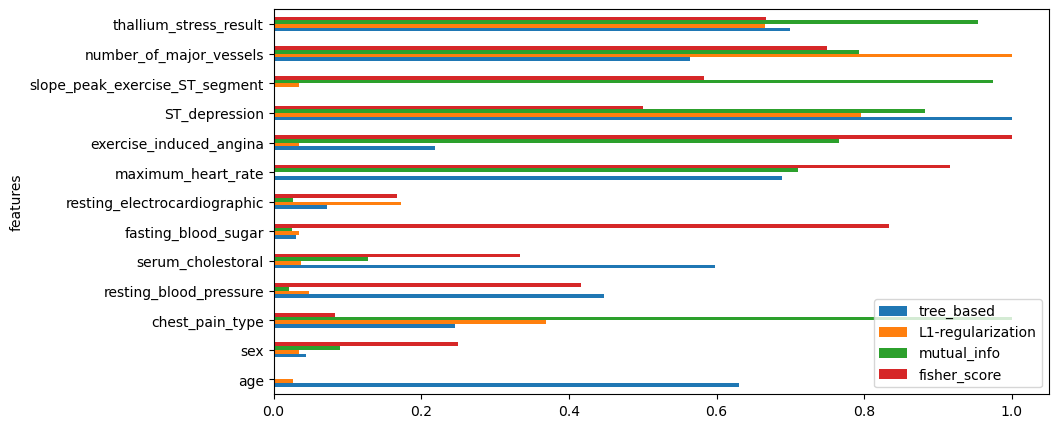

In [199]:
# Compare between filter method and embedded method performance
filter_embedded_comp.plot(kind="barh", figsize=(10, 5))

# sns.barplot(
#     x=filter_embedded_comp.index,
#     y=filter_embedded_comp.columns,
#     data=filter_embedded_comp,
# )
# plt.title("Filter Method vs Embedded Method")
# plt.grid()

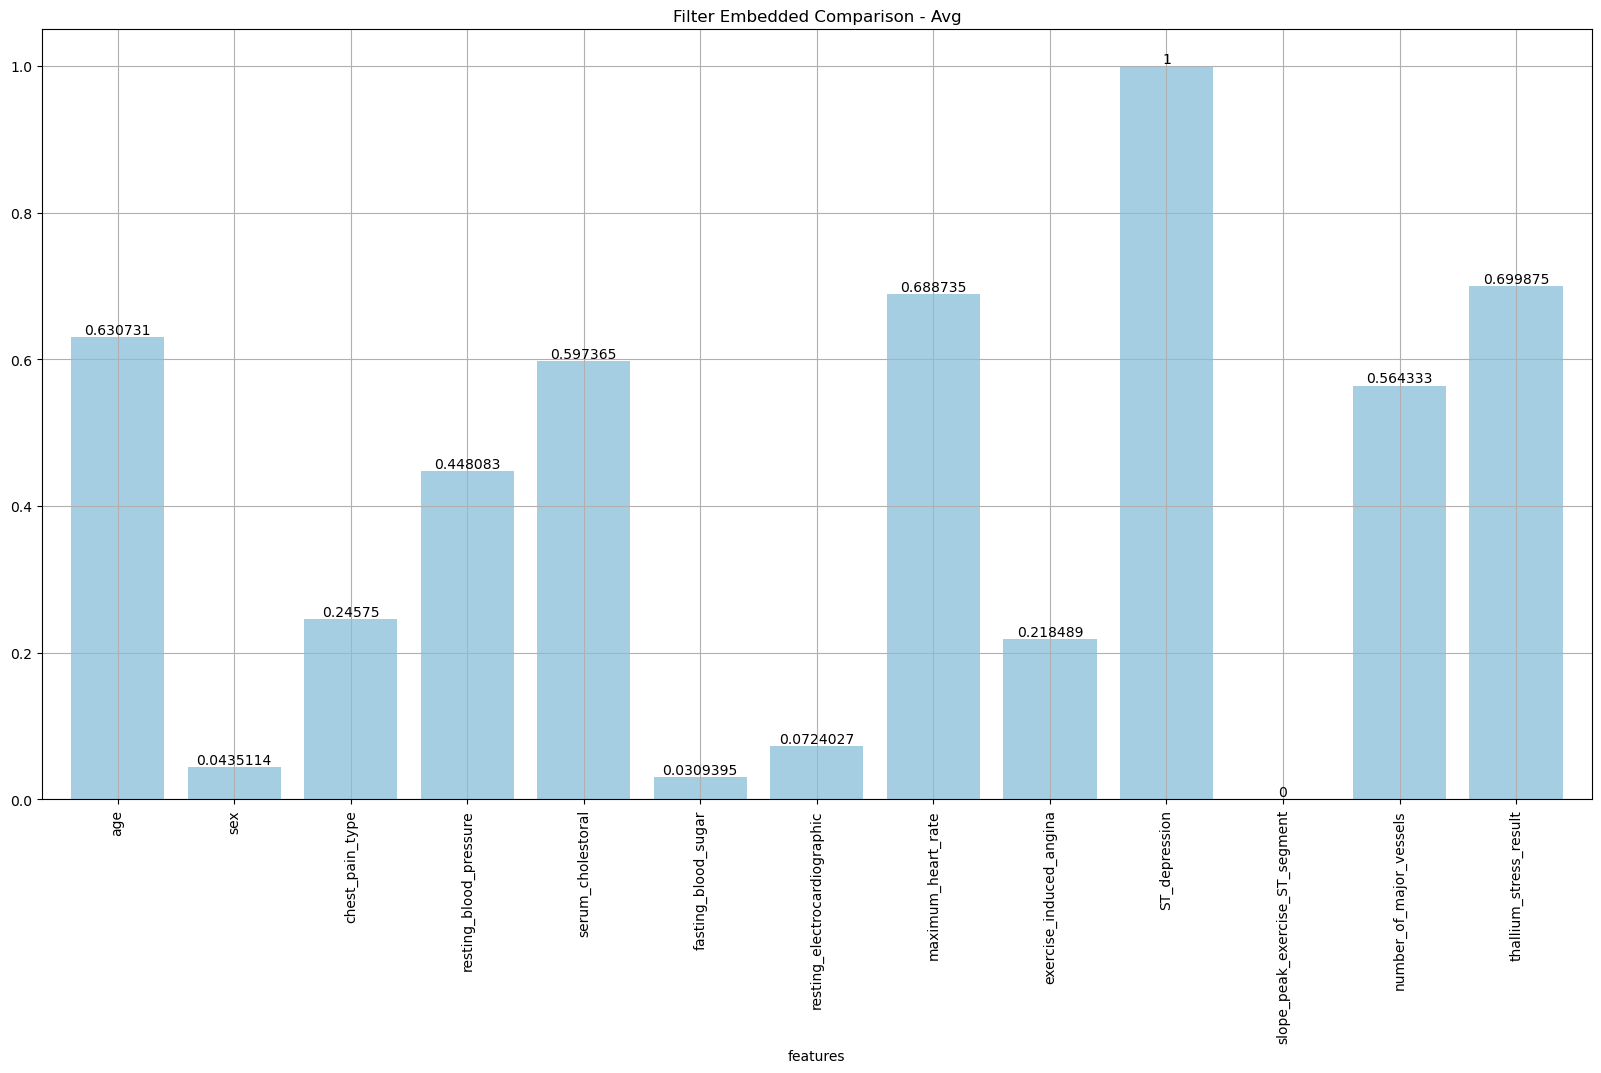

In [201]:
ax = filter_embedded_comp["tree_based"].plot.bar(
    width=0.8, figsize=(20, 10), colormap="Paired"
)

ax.bar_label(ax.containers[0])

plt.title("Filter Embedded Comparison - Avg")
plt.grid()

## Selected Features


In [202]:
# gg = mi_rank.get_largest_score(n=9) + ['target']
gg = filter_embedded_comp.nlargest(9, "Avg").index.to_list() + ["target"]
selected_train_data = train_data[gg]
selected_test_data = test_data[gg]

# selected_train_data = train_data[genetic_features.tolist() + ['target']]
# selected_test_data = test_data[genetic_features.tolist() + ['target']]

KeyError: 'Avg'

# Scaling

Normalizing features helps to increase model's accuracy


In [ ]:
scaled_train_data = selected_train_data.copy()
scaled_test_data = selected_test_data.copy()

norm_scaler = MinMaxScaler()
scaled_train_data[selected_train_data.columns[:-1]] = norm_scaler.fit_transform(
    scaled_train_data[selected_train_data.columns[:-1]]
)
scaled_test_data[selected_train_data.columns[:-1]] = norm_scaler.transform(
    scaled_test_data[selected_train_data.columns[:-1]]
)